# Классификация комментариев 

<font size = 4> **Описание проекта**
    
Интернет - магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в различных сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.      
В нашем распоряжении набор данных с разметкой о токсичности правок.

<font size = 4> **Цель проекта**

Нам нужно обучить модель машинного обучения классифицировать комментарии на позитивные и негативные (задача `NLP` - обработка естественного языка).   
Метрика качества работы модели: `F1`. Она должна быть не меньше 0.75.

<font size = 4> **План проекта** </font>  

**1.  Изучение данных.**    

1.1  Установим библиотеки.   
1.2  Импортируем библиотеки, модули, модели машинного обучения, способы работы с выборками, различные метрики.   
1.3  Считываем данные из `CSV-файла` в датафрейм и сохраняем в переменную **df.**   
1.4  Выводим основную информацию о датафрейме с помощью метода **info().**   


**2.  Исследование данных.**   

2.1  Проверим данные на наличие дубликатов.   
2.2  Исследуем баланс классов.   
2.3  Посмотрим на длины комментариев.   
2.4  Выполним частотный анализ текстов.   


**3.  Предобработка данных.**   

3.1  Создадим выборки из данных.   
3.2  Выполним токенизацию комментариев.   
3.3  Выполним преобразование данных в эмбединги.   


**4.  Обучение и анализ моделей.**   

4.1  Создадим функцию для обучения моделей, вывода метрик и графиков.    
4.2  Исследуем модель классификации **LogisticRegression.**           
4.3  Исследуем модель классификации **RandomForestClassifier.**     
4.4  Исследуем модель классификации **CatBoostClassifier.**     
4.5  Проверим лучшую модель на тестовой выборке.      


**5.  Общий вывод.**   

## Изучение данных

### Установим библиотеки.

In [ ]:
pip install wordcloud

In [ ]:
pip install optuna

In [ ]:
pip install torch

In [ ]:
pip install transformers

In [ ]:
pip install catboost

In [ ]:
pip install IPython

In [ ]:
# Загрузка стоп -слов из библиотеки nltk
nltk.download('stopwords')

### Импортируем библиотеки, модули, модели машинного обучения, способы работы с выборками, различные метрики.

In [1]:
# Импорт стандартных библиотек
import warnings
import re

# Из библиотеки collections импорт счётчика "Counter" для подсчёта слов в списке
from collections import Counter

# Импорт сторонних библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import torch

# Отключение предупреждений
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [2]:
# Импорт моделей машинного обучения
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

# Импорт предобученного токенайзера и модели для получения эмбедингов (с платформы "Hugging Face")
from transformers import (AutoTokenizer,
                          AutoModel)

# Импорт метрик
from sklearn.metrics import (roc_auc_score,
                             f1_score,
                             precision_score,
                             recall_score,
                             precision_recall_curve,
                             roc_curve,
                             classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay)

# Импорт способов работы с выборками и функций кросс-валидации
from sklearn.model_selection import (train_test_split,
                                     cross_val_predict)

# Импорт индикатора выполнения
from tqdm import notebook

# Импорт токенайзера и стоп - слов из nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

# Импорт библиотеки для создания визуализации частотности слов 
from wordcloud import WordCloud

# Импорт способа использования синтаксиса Markdown при вводе текста в ячейке
from IPython.display import Markdown

# Задание константы 
RANDOM_STATE = 42

### Считываем данные из CSV-файла в датафрейм и сохраняем в переменную df.

In [3]:
try:
    df = pd.read_csv('d:/Data_science/Projects_jupiter/data/toxic_comments.csv')

except:
    df = pd.read_csv('/datasets/toxic_comments.csv')

In [4]:
# Вывод 10 случайных строк таблицы
df.sample(10)

,Unnamed: 0,text,toxic
73953,74025,"""\nWell done - it is a tricky subject area. Mi...",0
80028,80104,"""\n\n Please send me most recent text from my ...",0
157745,157904,Wikipedia:Peer review/Ananthabhadram \n\nCan y...,0
55005,55066,"""\n\nLogo uploaded and added to the article. T...",0
42356,42406,"For example, the biased Wikipedia article says...",0
98630,98726,. A quick look online will reveal that other t...,0
141854,142007,"""\n\n """"terrorism"""" again \n\nAn editor has tw...",0
71679,71749,"""\n\n Please do not vandalize pages, as you di...",0
79830,79906,p135 ... The secularism of the Zionists made t...,0
100599,100696,"RAPINI - video removed \n\nDear Sir, the youtu...",0


**Описание данных**
 
- `text` — текст комментария   
- `toxic` — является ли комментарий токсичным (целевой признак)

### Выводим основную информацию о датафрейме с помощью метода `info()`.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


**Замечание:**  Пропуски в данных отсутствуют.   
Столбец `Unnamed: 0` не несёт никакой смысловой нагрузки. Скорее всего это индексы которые остались при выгрузке данных. При этом значения не совпадают с основным индексом (есть значения больше, максимальных значений из основного индекса). Скорее всего какие-то данные были удалены из основного источника.   
Удалим этот столбец.

In [6]:
df = df.drop('Unnamed: 0', axis=1, errors='ignore')
df

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159287,""":::::And for the second time of asking, when ...",0
159288,You should be ashamed of yourself \n\nThat is ...,0
159289,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,And it looks like it was actually you who put ...,0


## Исследование данных
Сначала приведём все слова в текстах к нижнему регистру.

In [7]:
df['text'] = df['text'].str.lower()

### Проверим данные на наличие дубликатов.

In [8]:
# Подсчёт количества полных дубликатов
df.duplicated().sum()

45

In [9]:
# Удалим строки - дубликаты
df = df.drop_duplicates()
df.shape

(159247, 2)

**Замечание:**  Удалили 45 строк с дубликатами.

### Исследуем баланс классов.

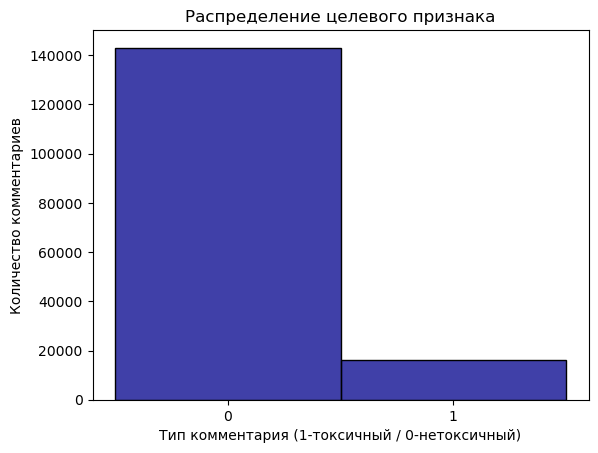

,Доля комментариев,Количество комментариев
0,0.898453,143076
1,0.101547,16171


In [10]:
# Построение гистограммы распределения признака
sns.histplot(df['toxic'].astype(str), color='darkblue')
plt.title('Распределение целевого признака')
plt.xlabel('Тип комментария (1-токсичный / 0-нетоксичный)')
plt.ylabel('Количество комментариев');
plt.show()

# Вывод значений в виде таблицы
pd.DataFrame({'Доля комментариев': df['toxic'].value_counts(normalize=True),
              'Количество комментариев' : df['toxic'].value_counts()})

**Замечание:**  В данных наблюдается явный дисбаланс классов. Возможно, нам потребуется бороться с ним при построении моделей машинного обучения.

### Посмотрим на длины комментариев.

In [11]:
# Преобразуем колонку с коментариями в список списков со словами из комментариев
comment_list = []
for string in df['text']: 
    comment_list.append(re.findall(r'[A-Za-z]+', string))
# Создадим список из длин комментариев
length_comment = []
for comment in comment_list:
    length_comment.append(len(comment))

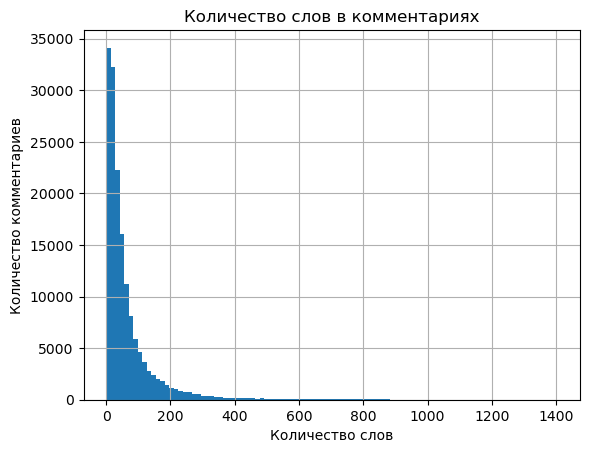

Самый длинный комментарий: 1403


In [12]:
# Построим гистограмму распределения комментариев по длинам
pd.Series(length_comment).hist(bins=100)
plt.xlabel('Количество слов');
plt.ylabel('Количество комментариев');
plt.title('Количество слов в комментариях');
plt.show()
print('Самый длинный комментарий:', max(length_comment))

**Замечание:**  Большинство комментариев состоят не более чем из 200 слов.  
Самый длинный комментарий состоит из 1403 слов.   

***Рассмотрим комментарии с длиной более 600 слов.***

In [13]:
# Увеличим длину отображаемой строки
pd.options.display.max_colwidth = 1000
# Отобразим 2 случайных комментария длиной более 600 слов
length = pd.Series(length_comment)
comments = pd.Series(comment_list)
com = comments[length > 600]
com.sample(2, random_state=RANDOM_STATE)

56718    [i, can, still, post, with, this, computer, i, said, block, me, come, the, fuck, down, here, and, arrest, me, san, diego, california, chula, vista, fucking, get, your, information, right, faggot, shithead, i, can, still, post, with, this, computer, i, said, block, me, come, the, fuck, down, here, and, arrest, me, san, diego, california, chula, vista, fucking, get, your, information, right, faggot, shithead, i, can, still, post, with, this, computer, i, said, block, me, come, the, fuck, down, here, and, arrest, me, san, diego, california, chula, vista, fucking, get, your, information, right, faggot, shithead, i, can, still, post, with, this, computer, ...]
81148                                                                                                                                                                                                 [take, that, in, the, ass, in, the, ass, in, the, ass, in, the, ass, in, the, ass, in, the, ass, in, the, ass, in, the, ass, in, 

In [14]:
# Сбросим до "дефолтной" длину отображаемой строки
pd.reset_option('^display.', silent=True)

# Посчитаем количество слов в случайной строке с помощью метода "Counter" из стандартной библиотеки "collections"
counter = Counter(com.iloc[200])
pd.Series(counter).sort_values(ascending=False)

shit         50
my           50
i            50
a            50
you          50
stop         25
piece        25
trip         25
power        25
admin        25
worthless    25
vandalism    25
consider     25
what         25
dont         25
give         25
editing      25
and          25
opinion      25
state        25
to           25
right        25
have         25
dipshit      25
posts        25
of           25
dtype: int64

**Замечание:**  Длинные комментарии (более 600 слов) имеют много повторяющихся слов.  
Особого смысла в их повторении нет. Слишком длинные комментарии можно обрезать.
Скорее всего это токсичные комментарии.


### Выполним частотный анализ текстов.

Результато этого анализа является список слов, наиболее часто встречающихся в тексте. Частотный анализ также позволяет получить представление о тематике и основных понятиях текста. Визуализировать его результаты удобно в виде "облака слов" (`WordCloud`). Эта диаграмма содержит слова, размер шрифта которых отражает их популярность в тексте.

Графики `WordCloud` будем строить на основе токенов. Токены получим с помощью метода `word_tokenize` из библиотеки `nltk`.

In [15]:
# Разделение комментариев на токсичные и нетоксичные
toxic = df[df['toxic'] == 1]
nontoxic = df[df['toxic'] == 0]

In [16]:
# Токенизация текста с помощью модуля "nltk"
toxic['text'] = toxic['text'].apply(lambda x: word_tokenize(x, language='english')) 
nontoxic['text']  = nontoxic['text'].apply(lambda x: word_tokenize(x, language='english')) 

In [17]:
# Вызов стоп-слов из библиотеки "nltk" и сохранение в переменную
stop = stopwords.words('english')
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [18]:
# Функция удаления стоп-слов из списка
def remove_stop_words(sentence):
    clean_sentence = ' '.join([token for token in sentence if token not in stop])
    return(clean_sentence)

In [19]:
# Токсичные и нетоксичные комментарии без стоп - слов
toxic_coms = toxic['text'].apply(remove_stop_words)
nontoxic_coms = nontoxic['text'].apply(remove_stop_words)

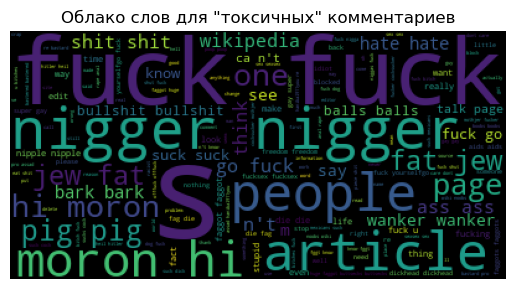

In [20]:
# Объединение всех токенов в одну строку
text_raw_toxic = " ".join(toxic_coms)
# Построение графика "WordCloud"
wordcloud_toxic = WordCloud(background_color='black', random_state=RANDOM_STATE).generate(text_raw_toxic)
plt.imshow(wordcloud_toxic)
plt.axis('off')
plt.title('Облако слов для "токсичных" комментариев')
plt.show()

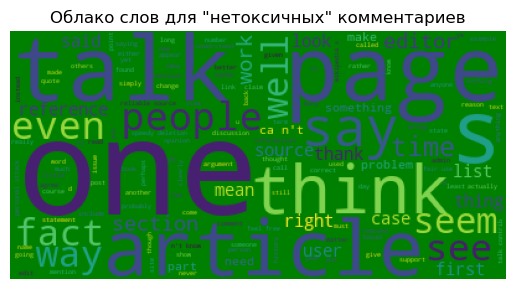

In [21]:
# Объединение всех токенов в одну строку
text_raw_nontoxic = " ".join(nontoxic_coms)
# Построение графика "WordCloud"
wordcloud_nontoxic = WordCloud(background_color='green', random_state=RANDOM_STATE).generate(text_raw_nontoxic)
plt.imshow(wordcloud_nontoxic)
plt.axis('off')
plt.title('Облако слов для "нетоксичных" комментариев')
plt.show()

**Замечание:**  На построенных графиках мы видим наиболее часто встречающиеся слова в токсичных и нетоксичных комментариях.

## Предобработка данных

### Создадим выборки из данных.
Сначала из всех данных случайным образом отберём 4000 строк и отложим для тестирования работы итоговой модели.

Так как в дальнейшем для получения эмбедингов из текстов комментариев мы будем использовать предобученную модель `Bert`, то для обучения модели попробуем взять всего лишь 2000 комментариев (в 2 раза меньше тестовой выборки).

In [22]:
# Сохранение целевого признака в переменную target и текстов комментариев в переменную features
target = df['toxic']
features = df['text']

In [23]:
# Разбиение данных на выборки
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            stratify=None,
                                                                            random_state=RANDOM_STATE,
                                                                            test_size=4000)    

# Вывод полученных размеров выборок на экран в виде таблицы
df_rezult = pd.DataFrame({'Shape': [features_train.shape,
                                    features_test.shape,
                                    target_train.shape,
                                    target_test.shape]},
                          index=['features_train',
                                 'features_test',
                                 'target_train',
                                 'target_test'])
display(df_rezult)
display(Markdown("<b>Баланс классов на тренировочной выборке</b>"))
print(target_train.value_counts(normalize=True))
display(Markdown('<b>Баланс классов на тестовой выборке</b>'))
print(target_test.value_counts(normalize=True))

,Shape
features_train,"(155247,)"
features_test,"(4000,)"
target_train,"(155247,)"
target_test,"(4000,)"


<b>Баланс классов на тренировочной выборке</b>

0    0.898555
1    0.101445
Name: toxic, dtype: float64


<b>Баланс классов на тестовой выборке</b>

0    0.8945
1    0.1055
Name: toxic, dtype: float64


**Замечание:**  Здесь мы создали отложенную (тестовую) выборку. Разделяя данные мы случайным образом их перемешивали и сознательно не использовали метод стратификации, чтобы сымитировать реальную ситуацию.

In [24]:
# Разбиение данных на выборки
features_train_2000, features_rest, target_train_2000, target_rest = train_test_split(features_train,
                                                                                      target_train,
                                                                                      stratify=target_train,
                                                                                      random_state=RANDOM_STATE,
                                                                                      train_size=2000)

# Вывод полученных размеров выборок на экран в виде таблицы
df_rezult = pd.DataFrame({'Shape': [features_train_2000.shape,
                                    features_rest.shape,
                                    target_train_2000.shape,
                                    target_rest.shape]},
                          index=['features_train_2000',
                                 'features_rest',
                                 'target_train_2000',
                                 'target_rest'])
display(df_rezult)
display(Markdown("<b>Баланс классов на тренировочной выборке в 2000 строк</b>"))
print(target_train.value_counts(normalize=True))
display(Markdown('<b>Баланс классов на оставшихся данных</b>'))
print(target_test.value_counts(normalize=True))

,Shape
features_train_2000,"(2000,)"
features_rest,"(153247,)"
target_train_2000,"(2000,)"
target_rest,"(153247,)"


<b>Баланс классов на тренировочной выборке в 2000 строк</b>

0    0.898555
1    0.101445
Name: toxic, dtype: float64


<b>Баланс классов на оставшихся данных</b>

0    0.8945
1    0.1055
Name: toxic, dtype: float64


**Замечание:**  Здесь мы случайным образом выбрали 2000 примеров для обучения моделей. Мы использовали стратификацию, чтобы сохранить баланс классов в нашей обучающей выборке. Так как данных у нас немного, мы можем получить худшие результаты предсказания если, например, в обучающей выборке окажется очень мало токсичных комментариев.

В результате у нас имеются:
- обучающая выборка (2000 строк),
- тестовая выборка (4000 строк).

### Выполним токенизацию комментариев.

Для того, чтобы предсказывать токсичность комментария с помощью модели машинного обучения, необходимо текстовый коментарий закодировать в числа.   
С помощью `Bert` получим эмбединги, предварительно выполнив токенизацию комментариев. Для этого мы воспользуемся предобученными моделями глубокого обучения. Выберем те, которые хорошо работают с токсичными текстами.

In [25]:
# Инициализация токенизатора 
model_name = 'unitary/toxic-bert'
default_tokenizer = AutoTokenizer.from_pretrained(model_name) 
default_tokenizer

BertTokenizerFast(name_or_path='unitary/toxic-bert', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

**Замечание:**  С помощью автокласса мы инициализировали модель токенизации.


In [26]:
# Функция токенизации текстовых признаков с помощью модели ('unitary/toxic-bert')
def tokenized(features, max_length=50):
    '''
    features - текстовые признаки 
    max_length - максимальная длина токенов
    '''
    tokenized_features = features.apply(lambda x: default_tokenizer.encode(x,
                                                                           truncation=True,
                                                                           max_length=max_length))
    return tokenized_features

In [27]:
# Токенизация комментариев тренировочной выборки в номера токенов из словаря (модели 'unitary/toxic-bert') методом encode()
tokenized_train_2000 = tokenized(features_train_2000)
tokenized_train_2000

86770     [101, 2144, 2043, 2079, 19628, 1997, 3327, 211...
25227     [101, 1000, 2062, 1997, 1996, 2168, 1024, 1015...
92135     [101, 12731, 3372, 9260, 2017, 2323, 2022, 279...
77572     [101, 7514, 2000, 2115, 7514, 1011, 2182, 2003...
18088     [101, 1000, 5121, 1012, 2006, 8299, 1024, 1013...
                                ...                        
32674     [101, 1000, 2035, 1997, 1996, 2117, 4400, 2323...
116818    [101, 1000, 1996, 2048, 4973, 2017, 2507, 2024...
20397     [101, 1000, 2079, 2025, 10086, 2030, 2695, 140...
41415     [101, 1000, 26203, 3972, 20624, 2239, 1997, 62...
94605     [101, 1057, 25394, 2791, 2003, 1037, 3043, 199...
Name: text, Length: 2000, dtype: object

In [28]:
# Токенизация комментариев тестовой выборки в номера токенов из словаря (модели 'unitary/toxic-bert') методом encode()
tokenized_test = tokenized(features_test)
tokenized_test

109595    [101, 1045, 2123, 1005, 1056, 2156, 1059, 1103...
48080     [101, 1000, 1996, 2744, 23207, 1998, 2198, 310...
91765     [101, 2969, 1011, 18140, 1024, 1045, 2031, 212...
19768     [101, 2053, 15508, 1010, 2009, 1005, 1055, 526...
144709    [101, 4283, 1012, 1045, 4964, 1996, 11091, 331...
                                ...                        
102488    [101, 1000, 8534, 2005, 3809, 13302, 1997, 105...
50987     [101, 2064, 2017, 3319, 2023, 8299, 1024, 1013...
44865     [101, 2122, 2052, 2036, 2991, 2046, 1996, 2270...
134256    [101, 4067, 2017, 2310, 7952, 2005, 2635, 2115...
35968     [101, 2106, 10334, 2655, 2005, 1037, 4773, 288...
Name: text, Length: 4000, dtype: object

In [29]:
# Функция выравнивания длин токенов методом padded (добавление 0) и создания компоненты модели attention_mask
def padded_attention_mask(tokens):
    '''
    tokens - токены
    '''
    # Поиск максимальной длины закодированных токенов
    max_len = 0
    for i in tokens.values:
        if len(i) > max_len:
            max_len = len(i)
        
    # Использование метода padding, для того чтобы длины закодированных токенов в корпусе были равными
    padded = np.array([i + [0] * (max_len - len(i)) for i in tokens.values])

    # Создание компоненты модели attention_mask (информация для модели, о том что нули не несут значимой информации)
    attention_mask = np.where(padded != 0, 1, 0)
    
    return padded, attention_mask

In [30]:
# Выравнивания длин токенов методом padded и создания компоненты модели attention_mask для тренировочной выборки
padded_train_2000, attention_mask_train_2000 = padded_attention_mask(tokenized_train_2000)
display(Markdown('**Shape of padded_train_2000**'), padded_train_2000.shape)
display(Markdown('**Shape of attention_mask_train_2000**'), attention_mask_train_2000.shape)


**Shape of padded_train_2000**

(2000, 50)

**Shape of attention_mask_train_2000**

(2000, 50)

In [31]:
# Выравнивания длин токенов методом padded и создания компоненты модели attention_mask для тестовой выборки
padded_test, attention_mask_test = padded_attention_mask(tokenized_test)
display(Markdown('**Shape of padded_test**'), padded_test.shape)
display(Markdown('**Shape of attention_mask_test**'), attention_mask_test.shape)

**Shape of padded_test**

(4000, 50)

**Shape of attention_mask_test**

(4000, 50)

**Замечание:**  Чтобы сократить время работы модели мы выполнили токенизацию с максимальной длиной 50. Модель поддерживает длину токенизации до 512 чисел.  

### Выполним преобразование данных в эмбединги.

На данном этапе с помощью предобученной  модели получим признаки - эмбединги на основе которых будет работать модель предсказания токсичности комментариев.

Эмбеддинги модель `Bert` создаёт батчами. Чтобы хватило оперативной памяти, сделаем размер батча небольшим `(batch_size=100)`.

In [32]:
# Инициализируем модель получения эмбедингов
default_model = AutoModel.from_pretrained(model_name)

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [33]:
# Функция для получения эмбедингов с помощью предобученной модели
def features(padded, attention_mask, batch_size=100):
    '''
    padded - токенизированные комментарии приведённые к единой длине
    attention_mask - "маска внимания" комментариев (информация для модели, о том что нули не несут значимой информации)
    batch_size - размер батча
    '''
    # Пустой список для хранения всех эмбедингов 
    embeddings = []
    for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        # Преобразуем данные и "маску внимания" в формат тензоров 
        batch = torch.LongTensor(padded[batch_size*i : batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i : batch_size*(i+1)])
        # Рассчёт эмбеддингов батча
        # Функция no_grad() указывает модели, что градиенты не нужны (обучение модели Bert не нужно)
        with torch.no_grad():
            batch_embeddings = default_model(batch, attention_mask=attention_mask_batch)
        # Приведение эмбеддингов батча к типу numpy.array и добавление в общий список эмбедингов
        embeddings.append(batch_embeddings[0][:,0,:].numpy())
    # Преобразование общего списка эмбеддингов в матрицу признаков 
    features = np.concatenate(embeddings)
    return features

In [34]:
# Получение эмбедингов на тренировочной выборке
features_train_2000 = features(padded_train_2000, attention_mask_train_2000, batch_size=100)
display(Markdown('**Shape of features_train_2000**'), features_train_2000.shape)

  0%|          | 0/20 [00:00<?, ?it/s]

**Shape of features_train_2000**

(2000, 768)

In [35]:
# Получение эмбедингов на тестовой выборке
features_test = features(padded_test, attention_mask_test, batch_size=100)
display(Markdown('**Shape of features_test_2000**'), features_test.shape)

  0%|          | 0/40 [00:00<?, ?it/s]

**Shape of features_test_2000**

(4000, 768)

**Замечание:** 
Выполнять данные преобразования (токенизация и получение эмбедингов) можно сразу для тренировочной и тестовой выборок вместе (до разделения).

## Обучение и анализ моделей

### Создадим функцию для обучения моделей, вывода метрик и графиков.

Обучать модели и подбтрать гиперпараметры будем на тренировочной выборке используя метод перекрёстной проверки.  
Для подбора гиперпараметров модели будем использовать фреймворк `Optuna`.  

In [36]:
# Функция для вывода метрик и графиков
def metrics_graph(target, features, model, cv):
    '''
    target - целевой признак
    features - признаки на которых обучается модель
    model - модель машинного обучения
    cv - количество фолдов кросс - валидации
    '''
    # Получение предсказаний модели
    predict = cross_val_predict(model,
                                features,
                                target,
                                cv=cv)

    # Построение матрицы ошибок
    cm = confusion_matrix(target, predict)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    # Получение вероятностей классов
    probabilities_valid = cross_val_predict(model,
                                            features,
                                            target,
                                            cv=cv,
                                            method='predict_proba')
    
    # Сохранение в переменную вероятностей класса "1"
    probabilities_one_valid = probabilities_valid[:,1]
    
    # Вывод на экран значений метрик precision, recall, f1-score для различных значений порога классификации (threshold)
    for threshold in np.arange(0, 1, 0.05):
        predicted_class = probabilities_one_valid > threshold 
        precision = precision_score(target, predicted_class) 
        recall = recall_score(target, predicted_class) 
        f1 = f1_score(target, predicted_class)
        print("Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f} | F1-score = {:.3f}".format(threshold,
                                                                                                    precision,
                                                                                                    recall,
                                                                                                    f1))

    # Вывод PR-кривой
    precision, recall, thresholds = precision_recall_curve(target, probabilities_one_valid)
    plt.figure(figsize=(6, 6))
    plt.step(recall, precision, where='post', label=f'F1-score: {(f1_score(target, predict)).mean().round(5)}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])
    plt.title('Кривая Precision-Recall')
    plt.legend(loc=4)
    plt.show() 
    
    # Вывод значений метрик классификации
    print(classification_report(target, predict))
    
    # Вывод ROC-кривой
    fpr, tpr, thresholds = roc_curve(target, probabilities_one_valid)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'AUC-ROC: {(roc_auc_score(target, probabilities_one_valid)).mean().round(5)}')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.title('ROC-кривая')
    plt.legend(loc=4)
    plt.show() 

### Исследуем модель классификации  `LogisticRegression`.

In [37]:
# Функция для обучения и предсказания модели с перебором гиперпараметров
def objective_1(trial, cv=3):
    # Создание переменной для перебора гиперпараметров
    params = {'max_iter': trial.suggest_int('max_iter', 10, 1000),
              'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga'])}
    # Инициализация модели машинного обучения
    model = LogisticRegression(**params,
                               random_state=RANDOM_STATE,
                               class_weight='balanced')
    # Обучение и получение предсказаний модели (методом кросс-валидации)
    predict = cross_val_predict(model, features_train_2000, target_train_2000, cv=cv, method='predict')
    # Возврат значения f1-score
    return f1_score(target_train_2000, predict)

# Обучение модели с перебором гиперпараметров с помощью модуля optuna максимизируя результат выполнения функици objective_1
study = optuna.create_study(direction='maximize')
study.optimize(objective_1, n_trials=10)
# Вывод оптимальных гиперпараметров модели
best_params_1 = study.best_params
print(best_params_1)

[I 2023-11-21 18:09:17,889] A new study created in memory with name: no-name-5f2e04ae-f17b-4070-916a-0e33f4dbf9fc
[I 2023-11-21 18:09:18,547] Trial 0 finished with value: 0.8529411764705881 and parameters: {'max_iter': 542, 'solver': 'liblinear'}. Best is trial 0 with value: 0.8529411764705881.
[I 2023-11-21 18:09:19,236] Trial 1 finished with value: 0.8529411764705881 and parameters: {'max_iter': 954, 'solver': 'liblinear'}. Best is trial 0 with value: 0.8529411764705881.
[I 2023-11-21 18:09:27,879] Trial 2 finished with value: 0.8508557457212713 and parameters: {'max_iter': 912, 'solver': 'saga'}. Best is trial 0 with value: 0.8529411764705881.
[I 2023-11-21 18:09:36,399] Trial 3 finished with value: 0.8508557457212713 and parameters: {'max_iter': 706, 'solver': 'saga'}. Best is trial 0 with value: 0.8529411764705881.
[I 2023-11-21 18:09:36,685] Trial 4 finished with value: 0.8472906403940886 and parameters: {'max_iter': 536, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.85294117

{'max_iter': 542, 'solver': 'liblinear'}


In [38]:
# Сохранение модели машинного обучения с оптимальными гиперпараметрами
best_model_1 = LogisticRegression(**best_params_1,
                                  random_state=RANDOM_STATE,
                                  class_weight='balanced')

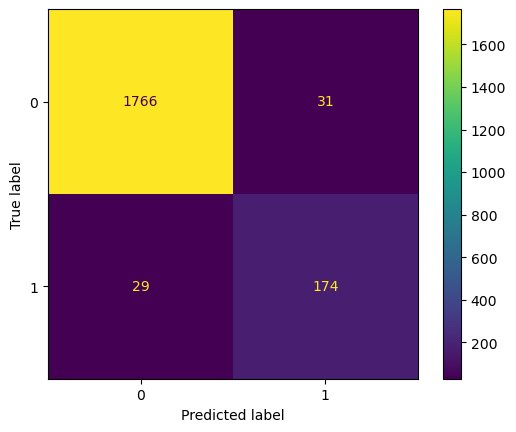

Threshold = 0.00 | Precision = 0.102, Recall = 1.000 | F1-score = 0.184
Threshold = 0.05 | Precision = 0.395, Recall = 0.921 | F1-score = 0.552
Threshold = 0.10 | Precision = 0.548, Recall = 0.892 | F1-score = 0.679
Threshold = 0.15 | Precision = 0.645, Recall = 0.887 | F1-score = 0.747
Threshold = 0.20 | Precision = 0.713, Recall = 0.882 | F1-score = 0.789
Threshold = 0.25 | Precision = 0.752, Recall = 0.882 | F1-score = 0.812
Threshold = 0.30 | Precision = 0.770, Recall = 0.872 | F1-score = 0.818
Threshold = 0.35 | Precision = 0.801, Recall = 0.872 | F1-score = 0.835
Threshold = 0.40 | Precision = 0.819, Recall = 0.867 | F1-score = 0.842
Threshold = 0.45 | Precision = 0.833, Recall = 0.857 | F1-score = 0.845
Threshold = 0.50 | Precision = 0.849, Recall = 0.857 | F1-score = 0.853
Threshold = 0.55 | Precision = 0.861, Recall = 0.852 | F1-score = 0.856
Threshold = 0.60 | Precision = 0.865, Recall = 0.852 | F1-score = 0.859
Threshold = 0.65 | Precision = 0.872, Recall = 0.842 | F1-score 

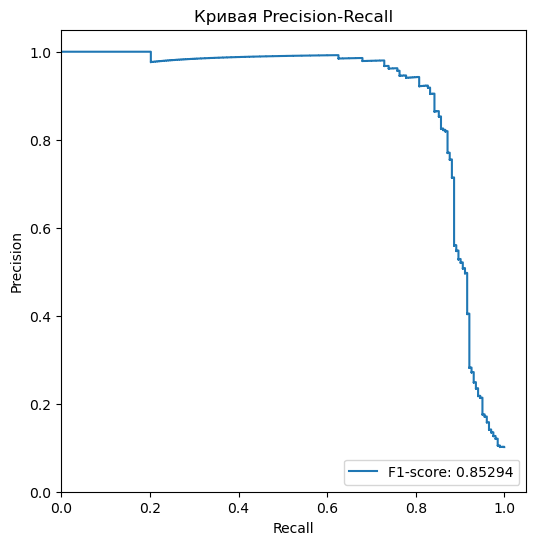

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1797
           1       0.85      0.86      0.85       203

    accuracy                           0.97      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.97      0.97      0.97      2000



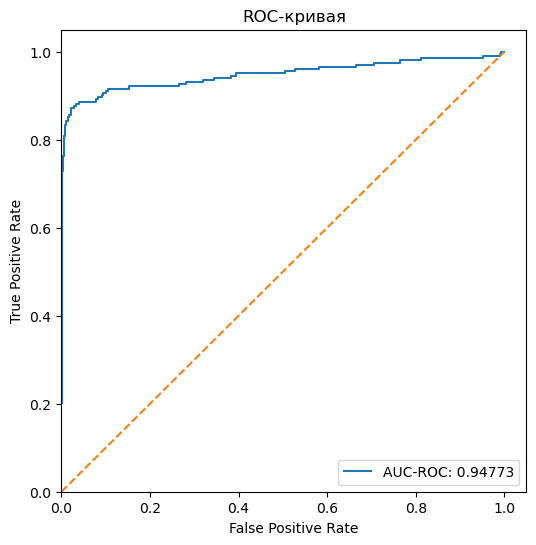

In [39]:
# Рассчёт метрик и вывод графиков
metrics_graph(target_train_2000, features_train_2000, best_model_1, 3)

### Исследуем модель классификации  `RandomForestClassifier`.

In [40]:
# Создадим функцию для обучения и предсказания модели с перебором гиперпараметров
def objective_2(trial, cv=3):
    # Создание переменной для перебора гиперпараметров
    params = {'max_depth': trial.suggest_int('max_depth', 1, 10),
              'n_estimators': trial.suggest_int('n_estimators', 10, 300)}
    # Инициализация модели машинного обучения
    model = RandomForestClassifier(**params,
                                   random_state=RANDOM_STATE,
                                   class_weight='balanced')
    # Обучение и получение предсказаний модели (методом кросс- валидации)
    predict = cross_val_predict(model, features_train_2000, target_train_2000, cv=cv, method='predict')
    # Возврат значения f1-score
    return f1_score(target_train_2000, predict)

# Обучение модели с перебором гиперпараметров с помощью модуля optuna максимизируя результат выполнения функици objective_2
study = optuna.create_study(direction='maximize')
study.optimize(objective_2, n_trials=10)
# Вывод оптимальных гиперпараметров модели
best_params_2 = study.best_params
print(best_params_2)

[I 2023-11-21 18:09:49,270] A new study created in memory with name: no-name-6413ebcc-4c2d-44db-bd3a-1618287d149d
[I 2023-11-21 18:09:58,269] Trial 0 finished with value: 0.8808290155440415 and parameters: {'max_depth': 9, 'n_estimators': 120}. Best is trial 0 with value: 0.8808290155440415.
[I 2023-11-21 18:10:03,280] Trial 1 finished with value: 0.8299319727891157 and parameters: {'max_depth': 1, 'n_estimators': 284}. Best is trial 0 with value: 0.8808290155440415.
[I 2023-11-21 18:10:06,763] Trial 2 finished with value: 0.8261851015801356 and parameters: {'max_depth': 1, 'n_estimators': 195}. Best is trial 0 with value: 0.8808290155440415.
[I 2023-11-21 18:10:10,367] Trial 3 finished with value: 0.8504672897196263 and parameters: {'max_depth': 2, 'n_estimators': 110}. Best is trial 0 with value: 0.8808290155440415.
[I 2023-11-21 18:10:30,068] Trial 4 finished with value: 0.8804071246819339 and parameters: {'max_depth': 6, 'n_estimators': 278}. Best is trial 0 with value: 0.880829015

{'max_depth': 9, 'n_estimators': 230}


In [41]:
# Создадим модель машинного обучения показавшую лучший результат
best_model_2 = RandomForestClassifier(**best_params_2,
                                      random_state=RANDOM_STATE,
                                      class_weight='balanced')

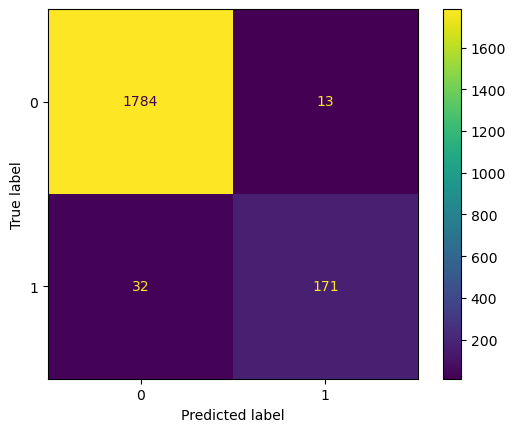

Threshold = 0.00 | Precision = 0.169, Recall = 0.975 | F1-score = 0.288
Threshold = 0.05 | Precision = 0.479, Recall = 0.916 | F1-score = 0.629
Threshold = 0.10 | Precision = 0.670, Recall = 0.901 | F1-score = 0.769
Threshold = 0.15 | Precision = 0.785, Recall = 0.901 | F1-score = 0.839
Threshold = 0.20 | Precision = 0.835, Recall = 0.897 | F1-score = 0.865
Threshold = 0.25 | Precision = 0.853, Recall = 0.887 | F1-score = 0.870
Threshold = 0.30 | Precision = 0.887, Recall = 0.887 | F1-score = 0.887
Threshold = 0.35 | Precision = 0.904, Recall = 0.877 | F1-score = 0.890
Threshold = 0.40 | Precision = 0.908, Recall = 0.872 | F1-score = 0.889
Threshold = 0.45 | Precision = 0.920, Recall = 0.847 | F1-score = 0.882
Threshold = 0.50 | Precision = 0.929, Recall = 0.842 | F1-score = 0.884
Threshold = 0.55 | Precision = 0.929, Recall = 0.833 | F1-score = 0.878
Threshold = 0.60 | Precision = 0.948, Recall = 0.808 | F1-score = 0.872
Threshold = 0.65 | Precision = 0.953, Recall = 0.798 | F1-score 

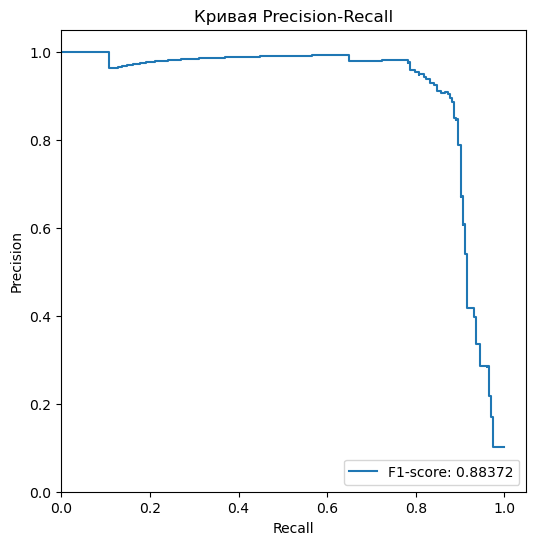

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1797
           1       0.93      0.84      0.88       203

    accuracy                           0.98      2000
   macro avg       0.96      0.92      0.94      2000
weighted avg       0.98      0.98      0.98      2000



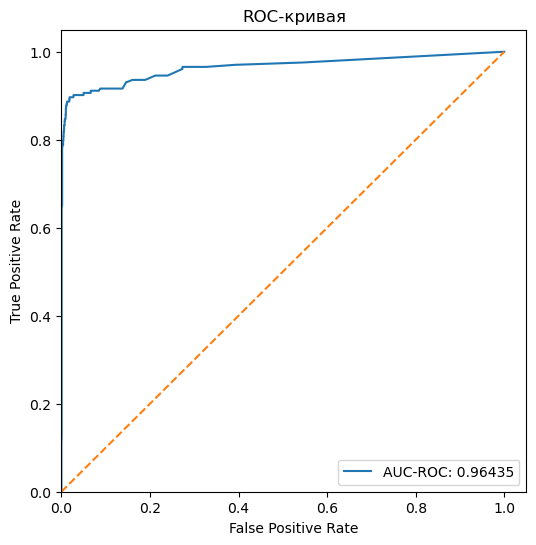

In [42]:
# Рассчитаем метрики и выведем графики
metrics_graph(target_train_2000, features_train_2000, best_model_2, 3)

### Исследуем модель классификации  `CatBoostClassifier`.

Для подбора гиперпараметров модели будем использовать фреймворк Optuna.


In [43]:
# Создадим функцию для обучения и предсказания модели с перебором гиперпараметров
def objective_3(trial, cv=3):
    # Создание переменной для перебора гиперпараметров
    params = {'depth': trial.suggest_int('depth', 3, 8),
              'iterations': trial.suggest_int('iterations', 5, 200)}
    # Инициализация модели машинного обучения
    model = CatBoostClassifier(**params,
                               random_state=RANDOM_STATE,
                               verbose=False)
    # Обучение и получение предсказаний модели (методом кросс- валидации)
    predict = cross_val_predict(model, features_train_2000, target_train_2000, cv=cv, method='predict')
    # Возврат значения f1-score
    return f1_score(target_train_2000, predict)

# Обучение модели с перебором гиперпараметров с помощью модуля optuna максимизируя результат выполнения функици objective_3
study = optuna.create_study(direction='maximize')
study.optimize(objective_3, n_trials=10)
# Вывод оптимальных гиперпараметров модели
best_params_3 = study.best_params
print(best_params_3)

[I 2023-11-21 18:12:05,739] A new study created in memory with name: no-name-b29c0dbd-37bf-49cb-90bb-a41b7069e0b0
[I 2023-11-21 18:12:13,287] Trial 0 finished with value: 0.8797953964194373 and parameters: {'depth': 5, 'iterations': 105}. Best is trial 0 with value: 0.8797953964194373.
[I 2023-11-21 18:12:24,168] Trial 1 finished with value: 0.8785529715762274 and parameters: {'depth': 5, 'iterations': 164}. Best is trial 0 with value: 0.8797953964194373.
[I 2023-11-21 18:12:28,858] Trial 2 finished with value: 0.8917525773195876 and parameters: {'depth': 4, 'iterations': 122}. Best is trial 2 with value: 0.8917525773195876.
[I 2023-11-21 18:12:40,689] Trial 3 finished with value: 0.8849104859335039 and parameters: {'depth': 7, 'iterations': 45}. Best is trial 2 with value: 0.8917525773195876.
[I 2023-11-21 18:13:13,678] Trial 4 finished with value: 0.8785529715762274 and parameters: {'depth': 7, 'iterations': 133}. Best is trial 2 with value: 0.8917525773195876.
[I 2023-11-21 18:13:19

{'depth': 6, 'iterations': 43}


In [44]:
# Создадим модель машинного обучения показавшую лучший результат
best_model_3 = CatBoostClassifier(**best_params_3,
                                  random_state=RANDOM_STATE,
                                  verbose=False)

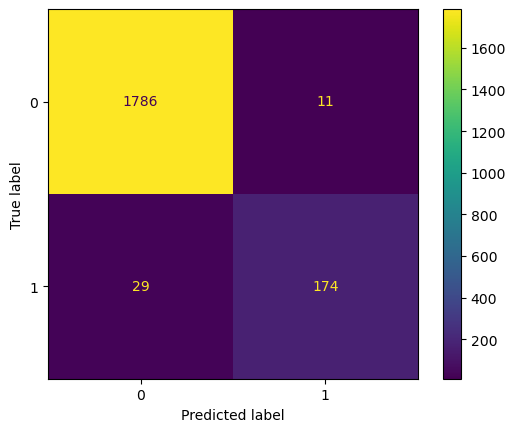

Threshold = 0.00 | Precision = 0.102, Recall = 1.000 | F1-score = 0.184
Threshold = 0.05 | Precision = 0.728, Recall = 0.897 | F1-score = 0.804
Threshold = 0.10 | Precision = 0.811, Recall = 0.887 | F1-score = 0.847
Threshold = 0.15 | Precision = 0.848, Recall = 0.877 | F1-score = 0.862
Threshold = 0.20 | Precision = 0.854, Recall = 0.867 | F1-score = 0.861
Threshold = 0.25 | Precision = 0.871, Recall = 0.867 | F1-score = 0.869
Threshold = 0.30 | Precision = 0.884, Recall = 0.867 | F1-score = 0.876
Threshold = 0.35 | Precision = 0.911, Recall = 0.862 | F1-score = 0.886
Threshold = 0.40 | Precision = 0.921, Recall = 0.857 | F1-score = 0.888
Threshold = 0.45 | Precision = 0.935, Recall = 0.857 | F1-score = 0.895
Threshold = 0.50 | Precision = 0.941, Recall = 0.857 | F1-score = 0.897
Threshold = 0.55 | Precision = 0.944, Recall = 0.837 | F1-score = 0.888
Threshold = 0.60 | Precision = 0.955, Recall = 0.837 | F1-score = 0.892
Threshold = 0.65 | Precision = 0.955, Recall = 0.828 | F1-score 

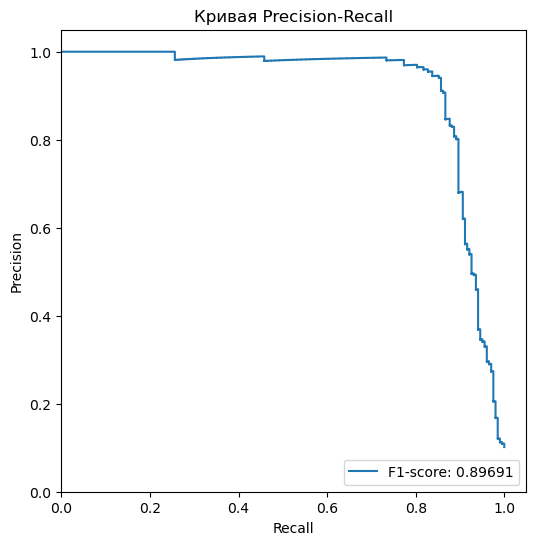

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1797
           1       0.94      0.86      0.90       203

    accuracy                           0.98      2000
   macro avg       0.96      0.93      0.94      2000
weighted avg       0.98      0.98      0.98      2000



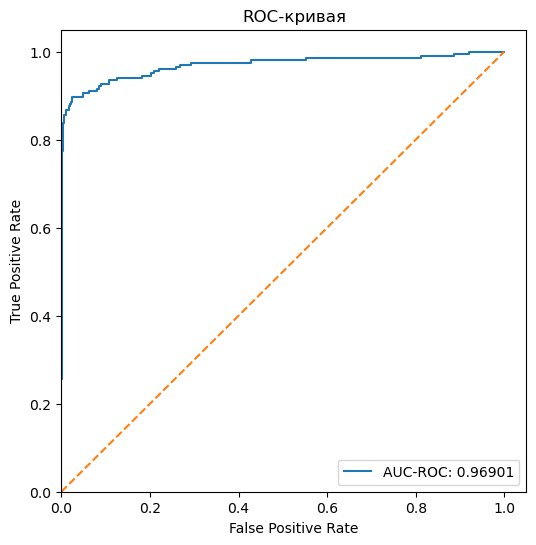

In [45]:
# Рассчитаем метрики и выведем графики
metrics_graph(target_train_2000, features_train_2000, best_model_3, 3)

**Замечание:**  Все модели показали хороший результат. В многом это благодаря тому что мы использовали предобученную под нашу задачу модель `Bert` для получения эмбедингов.   
В качестве итоговой модели выберем модель `CatBoostClassifier` с подобранными гиперпараметрами.

### Проверим лучшую модель на тестовой выборке.


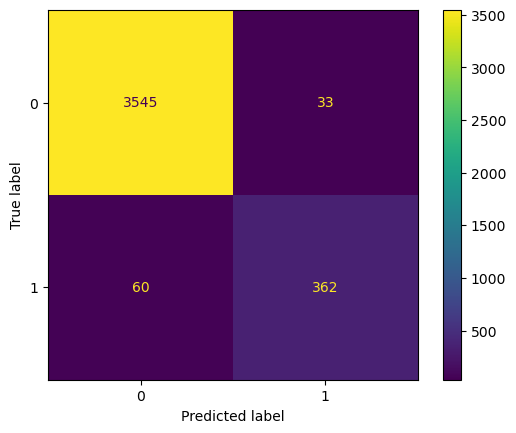

Threshold = 0.00 | Precision = 0.105, Recall = 1.000 | F1-score = 0.191
Threshold = 0.05 | Precision = 0.736, Recall = 0.927 | F1-score = 0.821
Threshold = 0.10 | Precision = 0.814, Recall = 0.910 | F1-score = 0.859
Threshold = 0.15 | Precision = 0.842, Recall = 0.898 | F1-score = 0.869
Threshold = 0.20 | Precision = 0.865, Recall = 0.893 | F1-score = 0.879
Threshold = 0.25 | Precision = 0.882, Recall = 0.886 | F1-score = 0.884
Threshold = 0.30 | Precision = 0.888, Recall = 0.882 | F1-score = 0.885
Threshold = 0.35 | Precision = 0.893, Recall = 0.874 | F1-score = 0.884
Threshold = 0.40 | Precision = 0.900, Recall = 0.872 | F1-score = 0.886
Threshold = 0.45 | Precision = 0.904, Recall = 0.867 | F1-score = 0.885
Threshold = 0.50 | Precision = 0.916, Recall = 0.858 | F1-score = 0.886
Threshold = 0.55 | Precision = 0.921, Recall = 0.858 | F1-score = 0.888
Threshold = 0.60 | Precision = 0.925, Recall = 0.853 | F1-score = 0.888
Threshold = 0.65 | Precision = 0.937, Recall = 0.846 | F1-score 

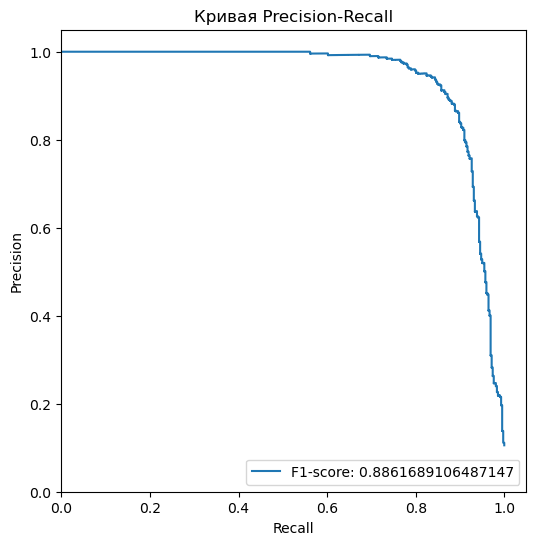

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3578
           1       0.92      0.86      0.89       422

    accuracy                           0.98      4000
   macro avg       0.95      0.92      0.94      4000
weighted avg       0.98      0.98      0.98      4000



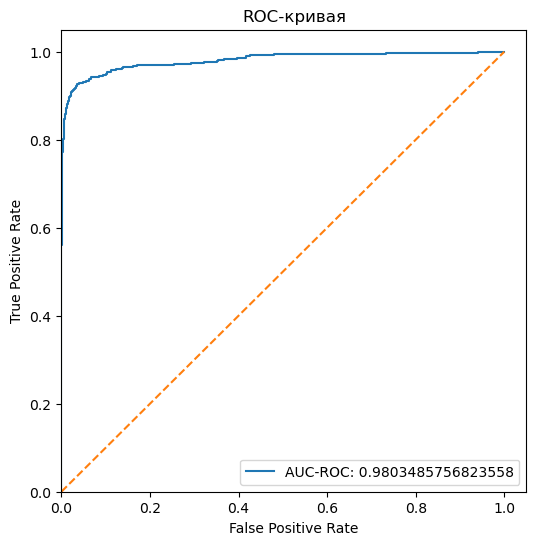

In [46]:
# Выбор тестовой модели
test_model = best_model_3

# Обучение и получение предсказаний тестовой модели
test_model.fit(features_train_2000, target_train_2000)
predict_test = test_model.predict(features_test)

# Построение матрицы ошибок
cm = confusion_matrix(target_test, predict_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Рассчёт вероятностей классов
probabilities_valid_test = test_model.predict_proba(features_test)
# Сохранение в переменную вероятностей класса "1"
probabilities_one_valid_test = probabilities_valid_test[:,1]
    
# Вывод на экран значений метрик precision, recall, f1-score для различных значений порога классификации (threshold)
for threshold in np.arange(0, 1, 0.05):
    predicted_class_test = probabilities_one_valid_test > threshold 
    precision = precision_score(target_test, predicted_class_test) 
    recall = recall_score(target_test, predicted_class_test) 
    f1 = f1_score(target_test, predicted_class_test)
    print("Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f} | F1-score = {:.3f}".format(threshold,
                                                                                                precision,
                                                                                                recall,
                                                                                                f1))

# Вывод PR-кривой
precision, recall, thresholds = precision_recall_curve(target_test, probabilities_one_valid_test)
plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post', label=f'F1-score: {f1_score(target_test, predict_test)}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.title('Кривая Precision-Recall')
plt.legend(loc=4)
plt.show() 
    
# Вывод значений метрик классификации
print(classification_report(target_test, predict_test))
    
# Вывод ROC-кривой
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid_test)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUC-ROC: {roc_auc_score(target_test, probabilities_one_valid_test)}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.title('ROC-кривая')
plt.legend(loc=4)
plt.show() 

**Замечание:**  На тестовой выборке модель показала хорошие результаты, которые удовлетворяют требованиям заказчика.

`f1-score` = 0.888

## Общий вывод

В данном проекте мы построили модель машинного обучения для интернет-магазина, которая будет искать токсичные комментарии. После этого можно отправлять их на модерацию.

**Этапы выполнения проекта:**
    
**Изучение данных.**   
На данном этапе мы импортировали различные библиотеки, считали и изучили данные.   

**Исследование данных.**     
Здесь мы выявили и удалили дубликаты. Далее, выявили дисбаланс классов: в имеющихся данных около 10 % комментариев - токсичные. 
Затем проанализировали длины комментариев и обрезали слишком длинные. В заключении провели частотный анализ слов и вывели наиболее часто встречающиеся слова в текстах.   

**Предобработка данных.**     
Сначала мы разделили данные на выборки. Затем текстовые коментарии закодировали в числа. Для этого мы использовали предобученные модели `Bert`. Этапы кодирования: токенизация, получение эмбедингов.   

**Обучение и анализ моделей.**   
На этой стадии проекта мы исследовали три типа моделей (`LogisticRegression`, `RandomForestClassifier`, `CatBoostClassifier`). Обучали модели и подбирали гиперпараметры на тренировочной выборке методом кросс-валидации. После этого лучшую модель проверили на тестовой (отложенной) выборке.

**В итоге:**  
В итоге нам удалось добиться очень хорошего качества модели на тестовой выборке:  **f1-score = 0.888.**  
Лучшая модель - `CatBoostClassifier`. 

В принципе, все исследуемые модели показали высокий результат. Это получилось, потому что для кодирования текстовых комментариев в признаки моделей мы использовали нейронные сети `Bert`, предообученные специально для выделения токсичных текстов.

Заметим, что нам хватило 2000 строк из всего датасета, чтобы обучить модели и получить высокое качество предсказаний.
Отложенная (тестовая) выборка в 2 раза больше тренировочной.

Помимо всего прочего, у одной и той же модели можно добиться различных значений `precision`, `recall` и `f1`, меняя значение порога классификации.
Возможно, заказчику окажется важнее всего не пропустить токсичный комментарий, и наиболее важной метрикой модели окажется `recall` (полнота).
В этом случае нам придётся уменьшить порог классификации  и пожертвовать точностью (`precision`) модели.